<a href="https://colab.research.google.com/github/JonJonDavidoff/DeepLearningFinalProject/blob/main/finalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Modules

In [1]:
import cv2 
import json
import os
import random
import math
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pdb
from google.colab.patches import cv2_imshow
from keras.applications import vgg16
from keras import layers
from keras import optimizers


# **Image Class Prep**


*Creating Folder for each passanger count*
- There are 5 data set (s1-5) and a json file for each set. 
- I will split up all images into correct folder


Data import and Split

In [ ]:
# this dataset holds all paths to images from a specifc class
data_set = {0: [] ,1 : [], 2 : [], 3: [], 4 : [], 5 : []}


The function moves a file from one directory to a diffrent one

In [ ]:
def move_file_to_dir(current_path, dir, img_name):
  parent_path = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass'
  original = r'' + str(current_path) + str(img_name)
  target = r'/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass/' + str(dir) + '/' + str(img_name)
  shutil.move(original, target)

In [ ]:
def split_data(data_set,json_data, img_foler_path):
  HEAD = "Head" # amount of heads = amount of passangers
  FILE_TYPE =  'jpg'
  for img in json_data: #img = an image from a dataset
    num_of_pass = 0
    for recognition in img['annotations']: # recognition = all part recognition (head, torso...)
      if not( FILE_TYPE in img['file']):
        break
      if recognition['label'] == HEAD: # head == 1 passanger
        num_of_pass += 1
    if not(num_of_pass > 5) and not(num_of_pass < 0): 
      current_path = img_foler_path + str(img['file']) #send to correct folder
      move_file_to_dir(img_foler_path, num_of_pass, img['file']) #add to correct directory
      data_set[num_of_pass].append(img['file']) # add path to dataset dict
  return data_set


This function adds a batch(s1-5) to the class folder split

In [ ]:
def add_batch_to_dataset(data_set, path, img_foler_path):
  file  = open(path)
  json_data = json.load(file)['frames']
  data_set = split_data(data_set,json_data,img_foler_path)
  return data_set

Send Images to Folder, used function on all folders/ batches from s1-5

In [ ]:

# data_set = add_batch_to_dataset(data_set,'/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/annotations/S5.json', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/S5/')


In [ ]:
#import splitfolders
# splitfolders.ratio('/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass', output="/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTrainTestSplit", seed=1337, ratio=(.8, 0.2, 0)) 

# **Split Images to Batches**

This function creates image data generators for model's and applies data engineering techniques

In [2]:
def get_train_val_generators():
  # path to train data
  train_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train' 
  # path to val data
  validation_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/val'
  # create data gen
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)
# get data from folder and apply data engineering techniques
  train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(150, 150),
  batch_size=32, 
  class_mode="categorical"
  )
# get data from folder and apply data engineering techniques
  validation_generator = test_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=32,
  class_mode="categorical")
# print  data shape
  for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
  return train_generator, validation_generator
 


# **DataSet Visualisaitions**

Visualize data grid

In [3]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
       plt.savefig(savename,bbox_inches='tight')

get train and val generator for grid demo

In [4]:
train_generator, validation_generator = get_train_val_generators()

Found 1022 images belonging to 6 classes.
Found 259 images belonging to 6 classes.
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 6)


In [5]:
x,y = next(train_generator)
print('x: ',type(x))
print('y: ',type(y))
print('x: ',x.shape)
print('y: ',y.shape)

x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (32, 150, 150, 3)
y:  (32, 6)


In [6]:
#Get class int vale from one hot encoded labels
y_int = np.argmax(y,axis=-1)

In [9]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

show grid

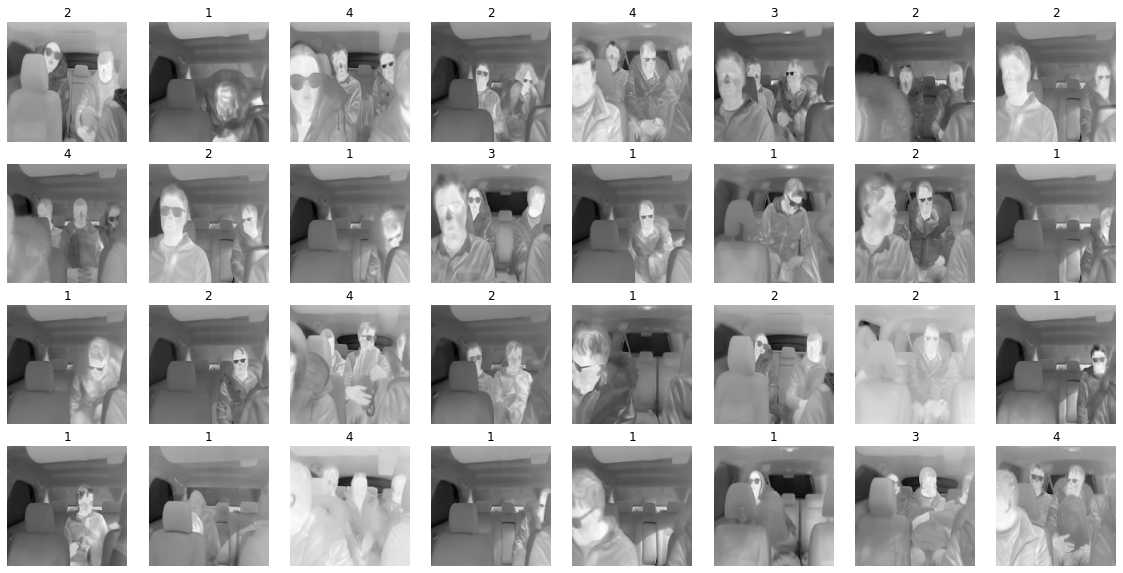

In [10]:
show_grid(x,4,8,label_list=y_int,show_labels=True,figsize=(20,10),savename='/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/image_grid.png')

# **First Model**

In [ ]:
# amount of classes - we have 6 diffrent passanger amount from 0-5
num_classes = 6
#  createa model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150,3)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)       0

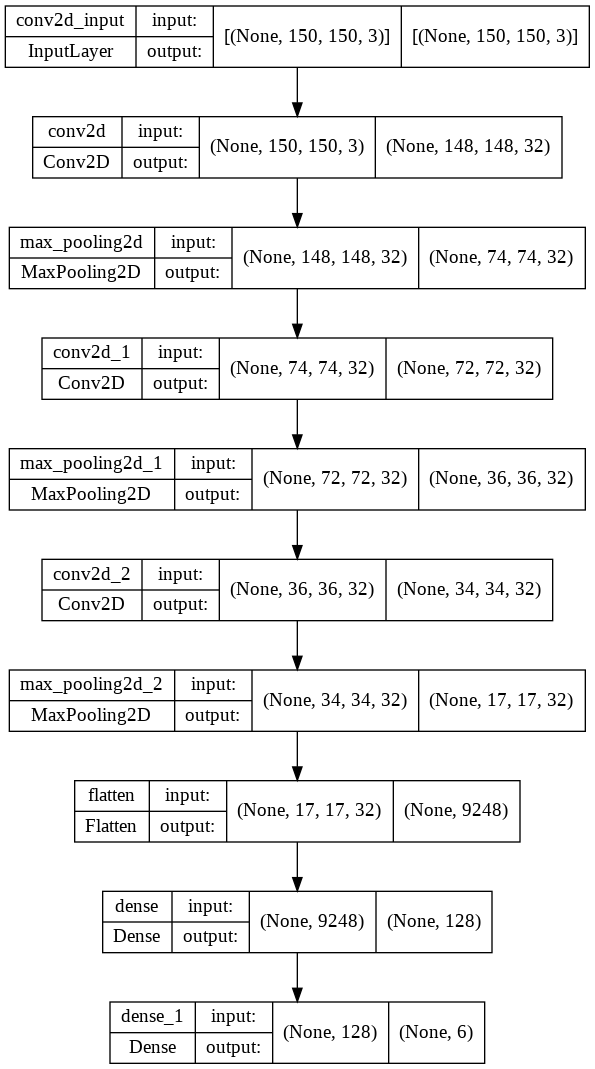

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='first_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
train_generator, validation_generator = get_train_val_generators()

Found 1022 images belonging to 6 classes.
Found 259 images belonging to 6 classes.
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 6)


In [ ]:
first_model_history = model.fit(
  train_generator,
  epochs=20,
  validation_data=validation_generator,
  steps_per_epoch=20
  )

Epoch 1/20
20/20 [==============================] - 136s 7s/step - loss: 1.7998 - accuracy: 0.3219 - val_loss: 1.3812 - val_accuracy: 0.4363
Epoch 2/20
20/20 [==============================] - 34s 2s/step - loss: 1.4901 - accuracy: 0.3953 - val_loss: 1.2586 - val_accuracy: 0.4672
Epoch 3/20
20/20 [==============================] - 15s 730ms/step - loss: 1.2195 - accuracy: 0.5313 - val_loss: 1.1117 - val_accuracy: 0.6139
Epoch 4/20
20/20 [==============================] - 12s 621ms/step - loss: 1.1755 - accuracy: 0.5422 - val_loss: 0.9615 - val_accuracy: 0.6525
Epoch 5/20
20/20 [==============================] - 12s 586ms/step - loss: 0.8684 - accuracy: 0.7022 - val_loss: 1.0494 - val_accuracy: 0.6371
Epoch 6/20
20/20 [==============================] - 12s 579ms/step - loss: 0.7578 - accuracy: 0.7273 - val_loss: 0.7485 - val_accuracy: 0.7220
Epoch 7/20
20/20 [==============================] - 12s 585ms/step - loss: 0.6664 - accuracy: 0.7469 - val_loss: 0.8098 - val_accuracy: 0.7181
Epoc

In [ ]:
np.save('first_model_train_history.npy', first_model_history.history)

In [ ]:
first_model_history = np.load('first_model_train_history.npy',allow_pickle='TRUE').item()
print(first_model_history)

{'loss': [1.7997856140136719, 1.4901100397109985, 1.2194527387619019, 1.1755458116531372, 0.8683850765228271, 0.7578169703483582, 0.6663740873336792, 0.6908745169639587, 0.550746500492096, 0.4705328047275543, 0.5608716607093811, 0.3688695430755615, 0.3351208567619324, 0.3391410708427429, 0.2646443545818329, 0.22825299203395844, 0.2340908646583557, 0.17071370780467987, 0.19578604400157928, 0.1875799000263214], 'accuracy': [0.3218750059604645, 0.39531248807907104, 0.5313479900360107, 0.542187511920929, 0.702194333076477, 0.7272727489471436, 0.746874988079071, 0.753918468952179, 0.8009404540061951, 0.8343750238418579, 0.8181818127632141, 0.8609374761581421, 0.8683385848999023, 0.869905948638916, 0.9012539386749268, 0.9137930870056152, 0.9200627207756042, 0.9435736536979675, 0.9312499761581421, 0.9420062899589539], 'val_loss': [1.3812370300292969, 1.2586218118667603, 1.111724853515625, 0.9615052342414856, 1.0493592023849487, 0.7484544515609741, 0.8098359107971191, 0.6447548270225525, 0.956

**`Visualize` First Model Results**

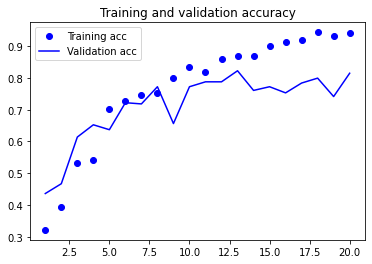

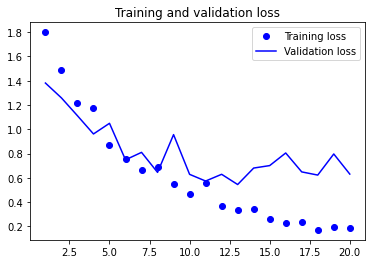

In [ ]:
acc = first_model_history['accuracy']
val_acc = first_model_history['val_accuracy']
loss = first_model_history['loss']
val_loss = first_model_history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#**Improved Model With More Layers**

Adding one more layer of conv2d + pooling for improved results

In [38]:
num_classes = 6

improved_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150,3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

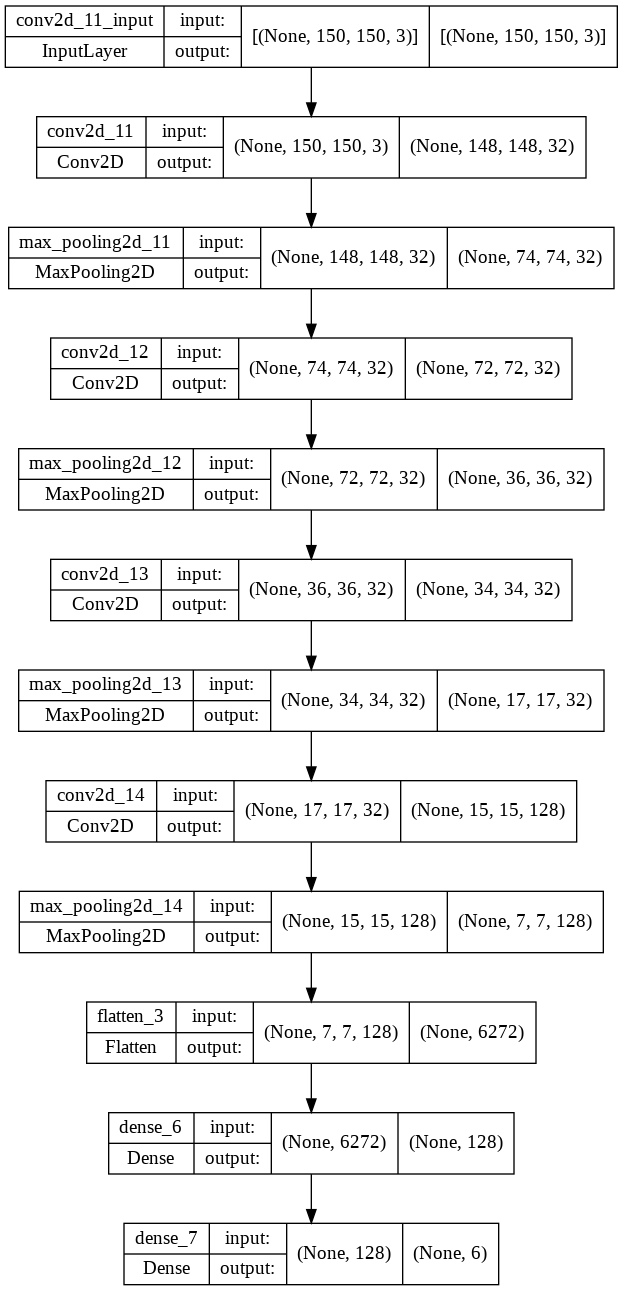

In [ ]:
plot_model(improved_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Prepare Callbacks

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')#stop model once there is no change
# save weights at a few points
mcp_save = ModelCheckpoint('/content/drive/MyDrive/ML_PROJECT_DATA/model_classifier.h5', save_best_only=True, monitor='val_loss', mode='min')
# when  a plateau occures the learning rate will reduce  
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
filename='history_log.csv'
history_logger= CSVLogger(filename, separator=",", append=False)

In [ ]:
train_generator, validation_generator = get_train_val_generators()

Found 1022 images belonging to 6 classes.
Found 259 images belonging to 6 classes.
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 6)


In [ ]:
BATCH_SIZE = 32
TRAINING_SIZE = 1022 
VALIDATION_SIZE = 259 
# total =1281
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
print(steps_per_epoch)


32


In [ ]:
improved_model.compile(loss = 'categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer='adam')

In [ ]:
history = improved_model.fit(train_generator,
                             validation_data = validation_generator, 
                             callbacks=[earlyStopping, mcp_save, reduce_lr_loss, history_logger], 
                             epochs=100)

Epoch 1/100
32/32 [==============================] - 19s 563ms/step - loss: 1.5384 - accuracy: 0.3063 - val_loss: 1.4615 - val_accuracy: 0.3127 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 18s 552ms/step - loss: 1.4240 - accuracy: 0.3356 - val_loss: 1.3205 - val_accuracy: 0.4247 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 18s 558ms/step - loss: 1.2153 - accuracy: 0.5235 - val_loss: 1.0492 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 18s 554ms/step - loss: 0.9564 - accuracy: 0.6409 - val_loss: 0.8419 - val_accuracy: 0.6641 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 18s 556ms/step - loss: 0.7282 - accuracy: 0.7309 - val_loss: 0.7114 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 18s 562ms/step - loss: 0.5660 - accuracy: 0.7965 - val_loss: 0.5848 - val_accuracy: 0.7954 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 18s 5

In [ ]:
np.save('train_history.npy',history.history)

In [39]:
improved_model.compile()

In [62]:
improved_model.load_weights('/content/drive/MyDrive/ML_PROJECT_DATA/model_classifier.h5')

# **Visualizing Model And Results**


In [ ]:
history = np.load('train_history.npy',allow_pickle='TRUE').item()
print(history)

{'loss': [1.5384225845336914, 1.424004077911377, 1.2152690887451172, 0.956390917301178, 0.7281676530838013, 0.5659700036048889, 0.4964335262775421, 0.4106387197971344, 0.37978532910346985, 0.3148352801799774, 0.2536819577217102, 0.21883131563663483, 0.22001317143440247, 0.1723550707101822, 0.16603371500968933, 0.15990130603313446, 0.12305595725774765, 0.07208632677793503, 0.0621681772172451], 'accuracy': [0.30626222491264343, 0.33561643958091736, 0.523483395576477, 0.640900194644928, 0.7309197783470154, 0.7964774966239929, 0.8082191944122314, 0.8424657583236694, 0.8512719869613647, 0.8845401406288147, 0.9178082346916199, 0.9256359934806824, 0.9119373559951782, 0.9481409192085266, 0.9324853420257568, 0.9383561611175537, 0.9540117383003235, 0.9735811948776245, 0.9784736037254333], 'val_loss': [1.4615122079849243, 1.3205348253250122, 1.0492445230484009, 0.841914713382721, 0.7114334106445312, 0.5848074555397034, 0.6316131949424744, 0.5428860187530518, 0.5412911176681519, 0.5823405981063843

**Visualising Training Results**

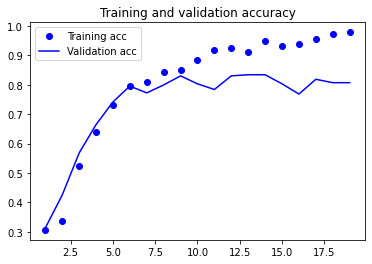

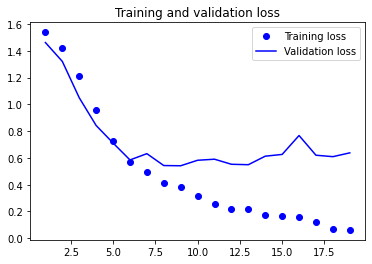

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Visulising Activitions**

In [54]:
by_class_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass/' # by class split directory path
file_name = '2/2018-03-15_12.24.38.346.jpg' # enter image name for display
img_path = by_class_dir + file_name  # path to image
img = image.load_img(img_path, target_size=(150,150)) # prepare image
img_tensor = image.img_to_array(img)  # transfor to tensor
img_tensor = np.expand_dims(img_tensor, axis=0) #expand tensor dimensions
img_tensor = preprocess_input(img_tensor)
img_tensor /= 255.# rescale to 0-1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


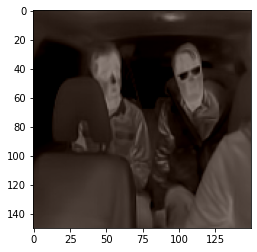

In [55]:
plt.imshow(img_tensor[0])
plt.show()

In [49]:
layer_outputs = [layer.output for layer in improved_model.layers[:8]]
activation_model = models.Model(inputs=improved_model.input, outputs=layer_outputs)

returns a list of activations

In [50]:
activations = activation_model.predict(img_tensor)

Get Names of the layers for the plot

In [52]:
layer_names = []
for layer in improved_model.layers[:8]:
  layer_names.append(layer.name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


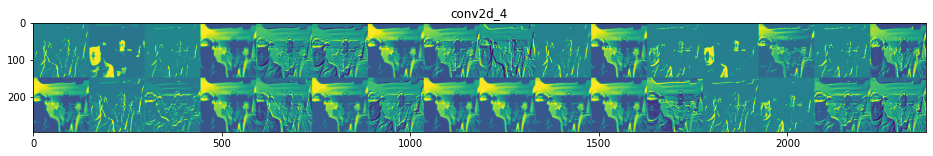

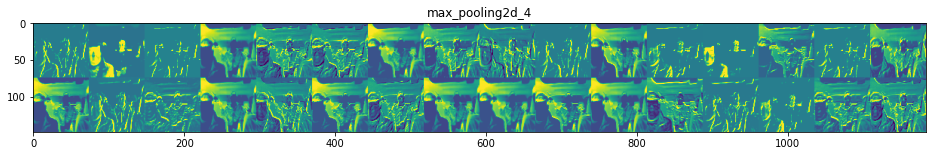

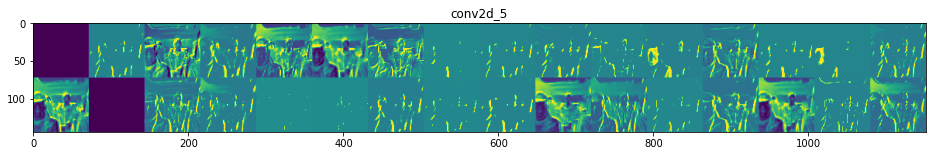

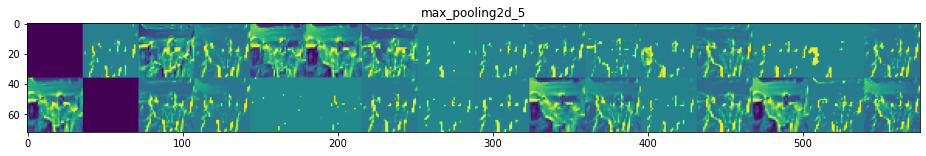

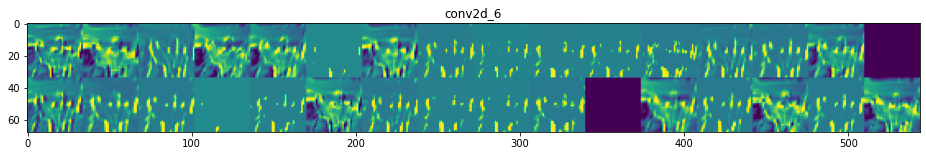

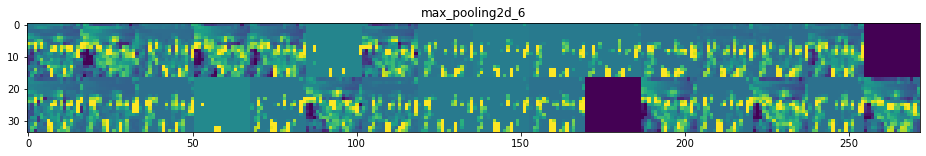

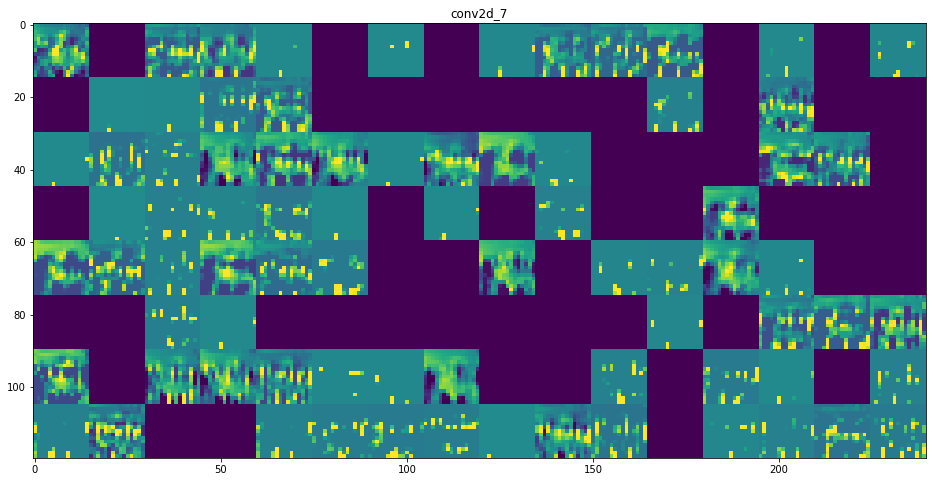

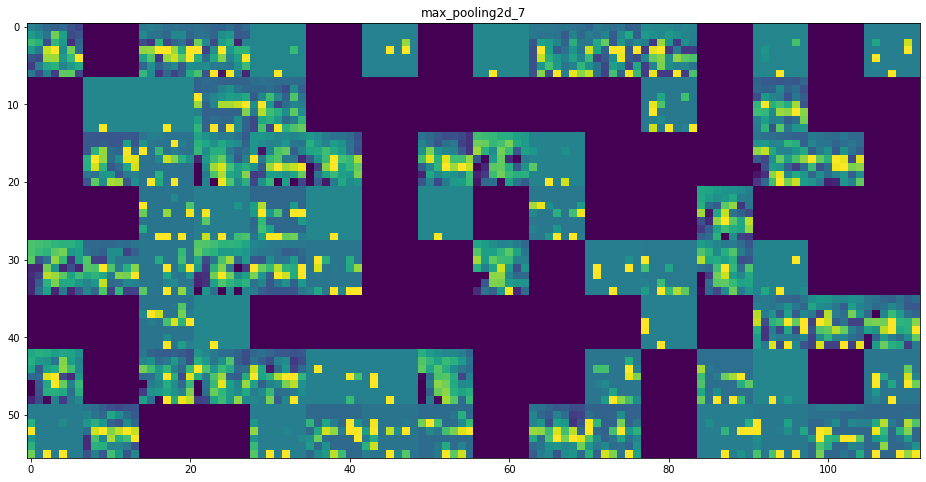

In [53]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :,col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
  scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')


**Visualize path from image to prediction**

In [57]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
by_class_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass/' # by class split directory path
file_name = '2/2018-03-15_12.24.38.346.jpg' # enter image name for display
img_path = by_class_dir + file_name  # path to image
img = load_img(img_path, target_size=(150, 150))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
feature_output = improved_model.predict(img)

**Predict function for UI**

In [ ]:
classes = train_generator.class_indices # diffrent class types
model_array = list(classes.keys())
print(model_array)

['0', '1', '2', '3', '4', '5']


The function displyes an image

In [ ]:
def display_image(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  cv2_imshow(img)

The predict function is mainly used in the UI. the function gets an image and the model predicts the amount of passangers

In [ ]:
def predict(img_path):
  img = image.load_img(img_path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  results = improved_model.predict(x)
  print(results)
  final_result = np.argmax(results[0])
  display_image(img_path)
  
  print("The predction is: ", final_result)
  

[[0. 0. 0. 0. 0. 1.]]


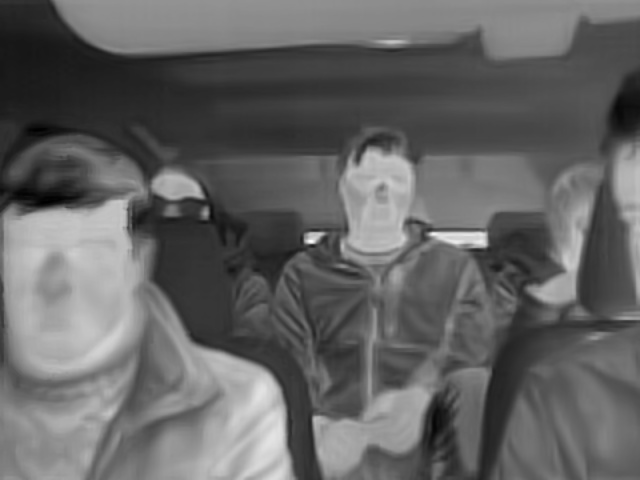

The predction is:  5


In [ ]:
# directories
by_class_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass/'
train_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train'
validation_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/val'
file_name = '5/2018-03-15_11.16.25.648.jpg'
predict(by_class_dir + file_name)

# **Using data augmentation with Improved Model**

add noise is a function that adds random noise to an image

In [6]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 10
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


setting data augmentation attributes to image data genaretor

In [7]:
datagen = ImageDataGenerator(
  width_shift_range=0.1,
  height_shift_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest',
  brightness_range=[0.2,1.0],
)



In [9]:
train_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train'
validation_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/val'
two_ppl_dir = train_dir + "/2"
#get a few image exampels
fnames = [os.path.join(two_ppl_dir, fname) for fname in os.listdir(two_ppl_dir)] 
# get an image example
img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150)) 


['/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.43.34.938.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.43.37.491.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.45.00.557.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.44.29.593.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.43.52.925.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.44.21.828.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.44.00.749.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.43.47.751.jpg', '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train/2/2018-03-15_10.44.13.750.jpg', 

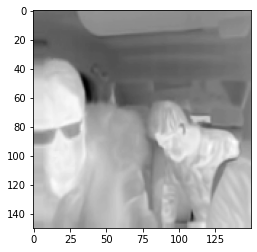

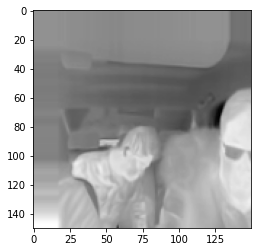

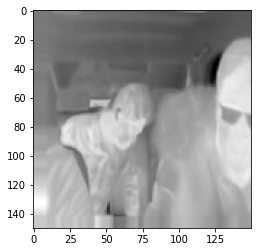

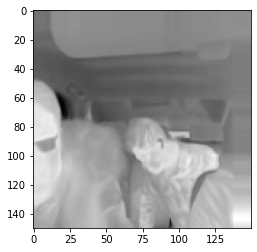

In [10]:
# reshape to array
img_tensor = image.img_to_array(img) # img tensor
img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
i=0
# ploting a few examples of data augemntaition
for batch in datagen.flow(img_tensor, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
plt.show()  

Preparing Images for model

In [25]:
# directories path
data_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass'
train_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train'
validation_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/val'

prepare data generator

In [26]:
train_datagen = ImageDataGenerator(
width_shift_range=0.1,
  height_shift_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest',
  brightness_range=[0.2,1.0])

Get Images 

In [27]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=32,
class_mode="categorical")


Found 1022 images belonging to 6 classes.


Create Validaition Generator 

In [28]:
val_datagen = ImageDataGenerator(rescale=1./255)

Get Images

In [29]:
validation_generator = val_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=32,
class_mode="categorical")

Found 259 images belonging to 6 classes.


Now we will use the improved model 

In [30]:
num_classes = 6

improved_model_data_aug = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150,3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

Prepare Callbacks

In [31]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min') #stop model once there is no change
# save weights at a few points
mcp_save = ModelCheckpoint('/content/drive/MyDrive/ML_PROJECT_DATA/model_data_aug_classifier.h5', save_best_only=True, monitor='val_loss', mode='min')
# when  a plateau occures the learning rate will reduce 
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
filename='history_aug_log.csv'
history_logger= CSVLogger(filename, separator=",", append=False)

In [32]:
improved_model_data_aug.compile(loss = 'categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer='adam')

In [33]:
history_data_aug = improved_model_data_aug.fit(train_generator,
                             validation_data = validation_generator, 
                             callbacks=[earlyStopping, mcp_save, reduce_lr_loss, history_logger], 
                             epochs=100)

Epoch 1/100
32/32 [==============================] - 17s 509ms/step - loss: 3.8490 - accuracy: 0.2544 - val_loss: 1.7626 - val_accuracy: 0.3127 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 18s 573ms/step - loss: 1.4797 - accuracy: 0.3317 - val_loss: 1.6591 - val_accuracy: 0.3127 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 16s 504ms/step - loss: 1.4621 - accuracy: 0.3337 - val_loss: 1.5693 - val_accuracy: 0.3127 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 16s 481ms/step - loss: 1.4118 - accuracy: 0.3356 - val_loss: 1.5726 - val_accuracy: 0.2432 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 15s 471ms/step - loss: 1.3689 - accuracy: 0.3875 - val_loss: 1.6229 - val_accuracy: 0.2432 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 15s 473ms/step - loss: 1.3460 - accuracy: 0.4002 - val_loss: 1.6282 - val_accuracy: 0.3127 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 16s 4

save training history

In [ ]:
np.save('train_history_data_aug.npy', history_data_aug.history)

load training history

In [ ]:
history_data_aug = np.load('train_history_data_aug.npy',allow_pickle='TRUE').item()
print(history_data_aug)

{'loss': [3.8104889392852783, 1.466070532798767, 1.386290431022644, 1.3375484943389893, 1.297626256942749, 1.311860203742981, 1.1943868398666382, 1.1633473634719849, 1.1313966512680054, 1.0906705856323242, 1.022135615348816, 0.9236986041069031, 1.0193426609039307, 0.9432042241096497, 0.9553953409194946, 0.9756117463111877, 0.8818672299385071, 0.8315123319625854, 0.8374738693237305, 0.777152419090271, 0.7418097853660583, 0.787668764591217, 0.7685915231704712, 0.7628087997436523, 0.775687038898468, 0.6894885301589966, 0.6817681789398193, 0.6715694069862366, 0.6849725842475891, 0.6516059637069702, 0.671805202960968, 0.6435762047767639, 0.5946142673492432, 0.6216054558753967, 0.6234140396118164, 0.6011044383049011, 0.5855962634086609, 0.5244786739349365, 0.5189206004142761, 0.5134120583534241, 0.4951501190662384], 'accuracy': [0.26516634225845337, 0.337573379278183, 0.395303338766098, 0.4217221140861511, 0.45009785890579224, 0.4461839497089386, 0.5225048661231995, 0.5215263962745667, 0.553

In [ ]:
history_data_aug = history_data_aug.history 

Plot training results

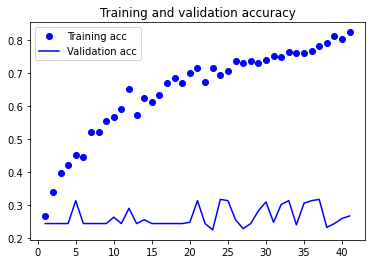

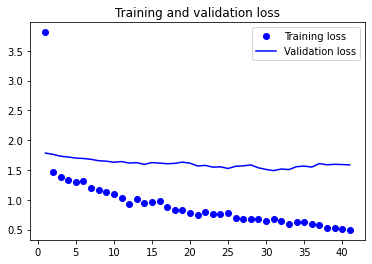

In [ ]:
acc = history_data_aug['accuracy']
val_acc = history_data_aug['val_accuracy']
loss = history_data_aug['loss']
val_loss = history_data_aug['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **VGG16 Model using Feature Extraction**

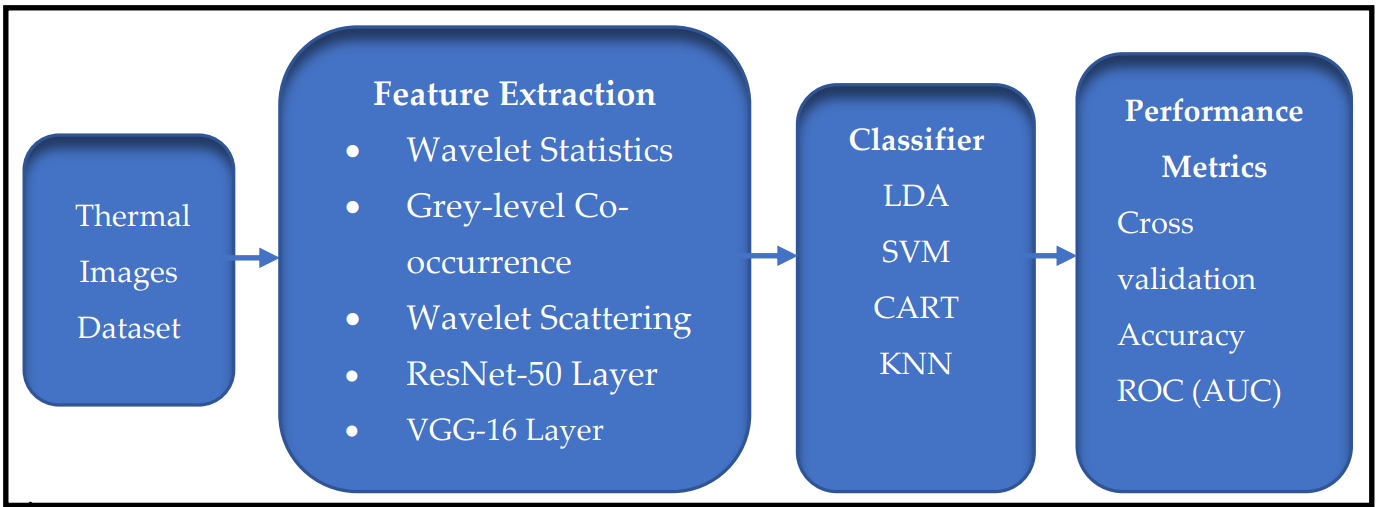

**VGG16 Set UP**

In [16]:
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**Extracting Features**

In [ ]:
data_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byClass'
train_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/train'
validation_dir = '/content/drive/MyDrive/ML_PROJECT_DATA/Thermal_Dataset/byTestTrainSplit/val'

In [13]:
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

extract_features is a function that extacts the features out of the convulotion base of the vgg16 model 

In [22]:
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512)) # create feature tensor
  labels = np.zeros(shape=(sample_count,6))# create label tensor
  # load images
  generator = datagen.flow_from_directory(
  directory,
  target_size=(150, 150),
  batch_size=batch_size)
  i=0
  for inputs_batch, labels_batch in generator:
    # feature extraction, prediction from conv base
    features_batch = conv_base.predict(inputs_batch)
    # add batch data to features data
    features[i * batch_size : (i + 1) * batch_size] = features_batch
     # add batch data to labels data
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

In [23]:
train_features, train_labels = extract_features(train_dir, 1022) # get features and labesl from training set
validation_features, validation_labels = extract_features(validation_dir, 259) # get features and labels from validation set

Found 1022 images belonging to 6 classes.
Found 259 images belonging to 6 classes.


In [ ]:
print(train_features.shape)
print(validation_features.shape)


(1022, 4, 4, 512)
(259, 4, 4, 512)


**Reshaping for Densely Connected Classifier** 

In [ ]:
train_features = np.reshape(train_features, (1022, 4*4* 512))
validation_features = np.reshape(validation_features, (259, 4*4* 512))

**Densely Connected Classifier** 

In [ ]:
vgg16_model = models.Sequential()
vgg16_model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
vgg16_model.add(layers.Dropout(0.5))
vgg16_model.add(layers.Dense(6, activation='softmax'))



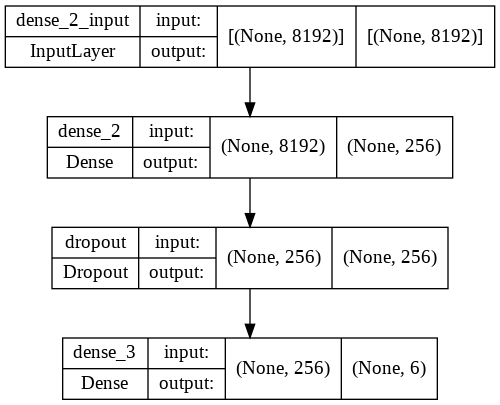

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(vgg16_model, to_file='vgg16_model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min') #stop model once there is no change
# save weights at a few points
mcp_save = ModelCheckpoint('/content/drive/MyDrive/ML_PROJECT_DATA/vgg16_classifier.h5, save_best_only=True, monitor='val_loss', mode='min')
# when  a plateau occures the learning rate will reduce 
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
filename='history_vgg16_log.csv'
history_logger= CSVLogger(filename, separator=",", append=False)

SyntaxError: ignored

In [ ]:
vgg16_model.compile(loss = 'categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer='adam')

In [ ]:
history_vgg16 = vgg16_model.fit(train_features,
                          train_labels,
                          callbacks=[earlyStopping, mcp_save, reduce_lr_loss, history_logger], 
                          epochs=100,
                          validation_data=(validation_features, validation_labels)
                          )

In [ ]:
np.save('train_history_vgg16.npy', history_vgg16.history)

In [ ]:
history_vgg16 = np.load('train_history_vgg16.npy',allow_pickle='TRUE').item()
print(history_vgg16)

{'loss': [1.3650920391082764, 0.9120063781738281, 0.7324162125587463, 0.6671128273010254, 0.6003945469856262, 0.5660452246665955, 0.524085521697998, 0.46891123056411743, 0.47514259815216064, 0.4074966311454773, 0.4149875044822693, 0.3999018371105194, 0.3909538686275482, 0.3343714475631714, 0.33526501059532166, 0.312363862991333, 0.30442485213279724, 0.2817147672176361, 0.2734717130661011, 0.24278026819229126, 0.23820002377033234, 0.24470236897468567, 0.22897063195705414, 0.20771485567092896, 0.1993023157119751, 0.17197194695472717, 0.1620497703552246, 0.14798225462436676, 0.14836454391479492, 0.15726925432682037, 0.13964788615703583, 0.136209636926651, 0.12962695956230164, 0.1395607888698578, 0.14458905160427094], 'accuracy': [0.47749510407447815, 0.6389432549476624, 0.7221134901046753, 0.7504892349243164, 0.7749511003494263, 0.7798434495925903, 0.8091976642608643, 0.8326810002326965, 0.8091976642608643, 0.8659490942955017, 0.8581213355064392, 0.8708415031433105, 0.8473581075668335, 0.

Plotting results

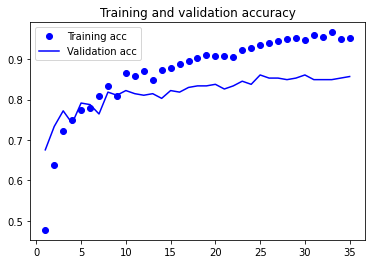

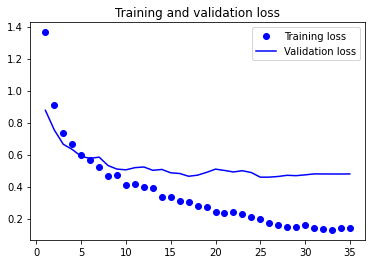

In [ ]:
acc = history_vgg16['accuracy']
val_acc = history_vgg16['val_accuracy']
loss = history_vgg16['loss']
val_loss = history_vgg16['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()